# A tutorial on model validation using deep generation of stress data

In [ ]:
!pip install git+https://github.com/airi-industrial-ai/dsc23-tutorial

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
import numpy as np
import requests
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler

/Users/vitalijpozdnakov/miniconda3/envs/genrisk/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from genrisk.shift import ConditionalShift
from genrisk.generation import TCNGAN, LSTMGAN

In [3]:
from dsctutorial.data import load_gas_supply
from dsctutorial.utils import positional_encoding, load_from_checkpoint
from dsctutorial.plot import hist2samp, pacf2samp
from dsctutorial.forecast import LSTMForecaster

## Dataset prepocessing

In [4]:
target = load_gas_supply()
target

Downloading...
From: https://drive.google.com/uc?id=1kGp65UabcFcKAHSM4K2MgkPAYgbyhQj5
To: /Users/vitalijpozdnakov/Yandex.Disk.localized/Data Science/dsc23-tutorial/notebooks/gas_supply.csv
100%|█████████████████████████████████████████████████████████████████████████████████████████| 28.8k/28.8k [00:00<00:00, 3.38MB/s]


,supply
date,
1991-02-08,6621
1991-02-15,6433
1991-02-22,6582
1991-03-01,7224
1991-03-08,6875
...,...
2019-10-04,9460
2019-10-11,9354
2019-10-18,9590


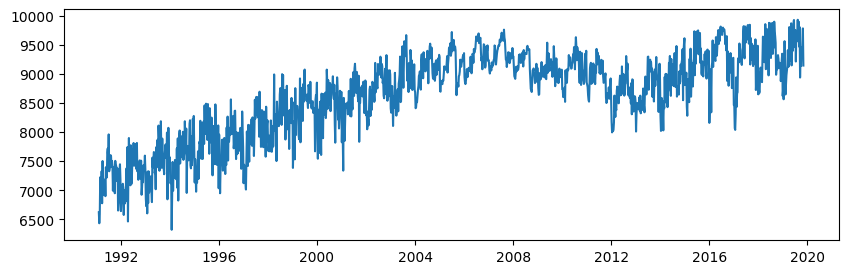

In [5]:
plt.figure(figsize=(10, 3))
plt.plot(target);

/Users/vitalijpozdnakov/Yandex.Disk.localized/Data Science/dsc23-tutorial/dsctutorial/utils.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(index, freq)


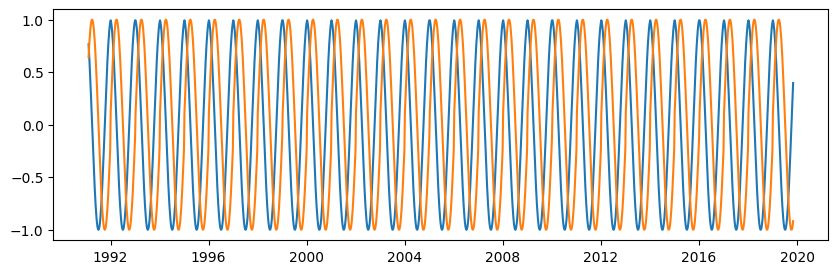

In [6]:
cov = positional_encoding(target.index, ['weekofyear'])
plt.figure(figsize=(10, 3))
plt.plot(cov);

In [7]:
split = target.index[int(len(target) * 0.7)]
train_target, test_target = target[:split], target[split:]
scaler = StandardScaler()
train_target[:] = scaler.fit_transform(train_target)
test_target[:] = scaler.transform(test_target)
train_cov, test_cov = cov[:split], cov[split:]
len(train_target), len(test_target)

/var/folders/ql/y19v0j4n6yg5h40t3thn30x00000gn/T/ipykernel_52409/2739815574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_target[:] = scaler.fit_transform(train_target)
/var/folders/ql/y19v0j4n6yg5h40t3thn30x00000gn/T/ipykernel_52409/2739815574.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_target[:] = scaler.transform(test_target)


(1051, 450)

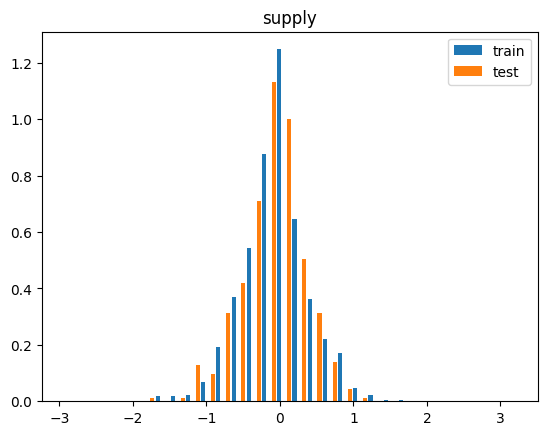

In [8]:
hist2samp(train_target, test_target, 'train', 'test', nbins=30)

## LSTM forecasting model

In [9]:
#lstm_model = LSTMForecaster(hidden_dim=64, window_size=100, lr=0.01, num_epochs=15, batch_size=32)
#lstm_model.fit(train_target, train_cov)

In [10]:
url = 'https://github.com/airi-industrial-ai/dsc23-tutorial/raw/main/weights/lstm-epoch=14-step=450.ckpt'
r = requests.get(url)
open('lstm-epoch=14-step=450.ckpt', 'wb').write(r.content);

In [11]:
lstm_model = LSTMForecaster(hidden_dim=64, window_size=100, lr=0.01, num_epochs=15, batch_size=32)
lstm_model.load_from_checkpoint(
    'lstm-epoch=14-step=450.ckpt',
    train_target,
    train_cov,
)

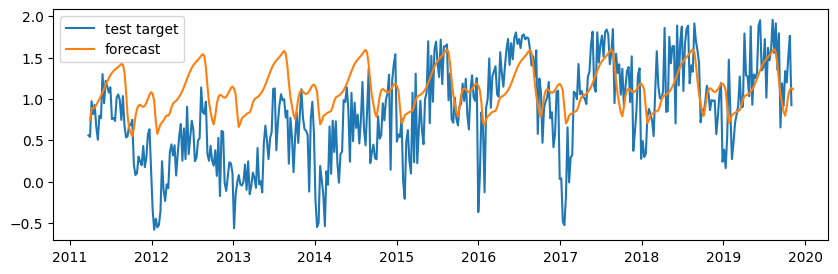

In [12]:
pred = lstm_model.predict(len(test_target), train_target, train_cov, test_cov)

plt.figure(figsize=(10, 3))
plt.plot(test_target, label='test target')
plt.plot(pred, label='forecast')
plt.legend()
plt.show()

## Backtesting of forecasting models

In [13]:
def backtest(model, input_size, horizon, target, cov):
    error = []
    for i in trange(len(target)-input_size-horizon+1):
        past_range = range(i, i+input_size)
        future_range = range(i+input_size, i+input_size+horizon)
        past_target = target.iloc[past_range]
        past_cov = cov.iloc[past_range]
        future_cov = cov.iloc[future_range]
        future_target = target.iloc[future_range]
        future_pred = model.predict(horizon, past_target, past_cov, future_cov)
        error.append(((future_target.values[-1] - future_pred.values[-1])**2).mean())
    return pd.Series(error, index=target.index[input_size-1:-horizon])

In [14]:
test_lstm_error = backtest(lstm_model, input_size=10, horizon=100, target=test_target, cov=test_cov)
test_lstm_error.mean()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 341/341 [00:14<00:00, 23.47it/s]


0.24856905466236778

## Worst-case risk estimation

In [15]:
def input_seq_dataset(input_size, horizon, target, cov, lags):
    input_seq = []
    for i in trange(len(target)-input_size-horizon+1):
        past_range = range(i, i+input_size)
        future_range = range(i+input_size, i+input_size+horizon)
        past_target = target.iloc[past_range]
        past_cov = cov.iloc[past_range]
        past_target_lags = []
        for j in range(lags):
            past_target_lags.append(past_target.iloc[-1, 0] - past_target.iloc[-2-j, 0])
        input = np.concatenate([past_target_lags, past_cov.iloc[-1].values])
        input_seq.append(input)
    columns = [f'{target.columns[0]}_diff{i+1}' for i in range(lags)] + list(cov.columns)
    input_seq = pd.DataFrame(input_seq, columns=columns, index=target.index[input_size-1:-horizon])
    return input_seq

In [16]:
test_input_seq = input_seq_dataset(
    input_size=10, horizon=100, target=test_target, cov=test_cov, lags=5)
test_input_seq

100%|██████████████████████████████████████████████████████████████████████████████████████████| 341/341 [00:00<00:00, 1232.61it/s]


,supply_diff1,supply_diff2,supply_diff3,supply_diff4,supply_diff5,weekofyear_cos,weekofyear_sin
date,,,,,,,
2011-05-27,0.532671,0.502495,0.793759,0.640255,0.371295,-0.766044,0.642788
2011-06-03,-0.351615,0.181056,0.150880,0.442143,0.288640,-0.835488,0.549509
2011-06-10,0.271584,-0.080032,0.452639,0.422463,0.713727,-0.893633,0.448799
2011-06-17,-0.066912,0.204672,-0.146944,0.385727,0.355551,-0.939693,0.342020
2011-06-24,-0.076096,-0.143008,0.128576,-0.223040,0.309632,-0.973045,0.230616
...,...,...,...,...,...,...,...
2017-11-03,0.045920,0.238784,0.472319,0.020992,0.334559,0.396080,-0.918216
2017-11-10,-0.425087,-0.379167,-0.186304,0.047232,-0.404095,0.500000,-0.866025
2017-11-17,0.554975,0.129888,0.175808,0.368671,0.602207,0.597159,-0.802123


In [17]:
mutable_columns = test_input_seq.columns[:-2].tolist()
immutable_columns = test_input_seq.columns[-2:].tolist()
mutable_columns, immutable_columns

(['supply_diff1',
  'supply_diff2',
  'supply_diff3',
  'supply_diff4',
  'supply_diff5'],
 ['weekofyear_cos', 'weekofyear_sin'])

In [18]:
alphaspace = np.linspace(0.1, 0.9, 9)
test_lstm_risk = []
for alpha in tqdm(alphaspace):
    shift_model = ConditionalShift(mutable_columns, immutable_columns, alpha=alpha)
    shift_model.fit(test_input_seq, test_lstm_error)
    test_lstm_risk.append((shift_model.risk, shift_model.lb_risk, shift_model.ub_risk))
test_lstm_risk = np.array(test_lstm_risk)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.71s/it]


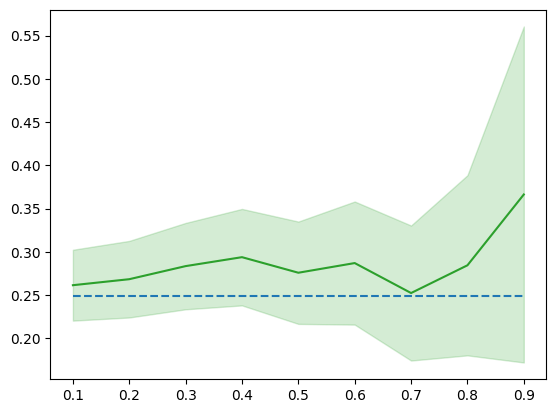

In [19]:
plt.plot(alphaspace, test_lstm_risk[:, 0], c='tab:green')
plt.fill_between(alphaspace, test_lstm_risk[:, 1], test_lstm_risk[:, 2], alpha=0.2, color='tab:green')
plt.hlines(test_lstm_error.mean(), alphaspace[0], alphaspace[-1], color='tab:blue', linestyles='dashed')
plt.show()

## Time series generation using conditional GAN

In [20]:
train_data = pd.concat([train_target, train_cov], axis=1)
test_data = pd.concat([test_target, test_cov], axis=1)

In [21]:
'''
gan = TCNGAN(
    target_columns=target.columns,
    conditional_columns=cov.columns,
    window_size=100,
    num_epochs=400,
    num_layers=1,
    hidden_dim=64,
    latent_dim=2,
    verbose=True,
    lr=0.01,
)
gan.fit(test_data)
''';

In [22]:
url = 'https://github.com/airi-industrial-ai/dsc23-tutorial/raw/main/weights/gan-epoch=399-step=26000.ckpt'
r = requests.get(url)
open('gan-epoch=399-step=26000.ckpt', 'wb').write(r.content);

In [23]:
gan = TCNGAN(
    target_columns=target.columns,
    conditional_columns=cov.columns,
    window_size=100,
    num_epochs=400,
    num_layers=1,
    hidden_dim=64,
    latent_dim=2,
    verbose=True,
    lr=0.01,
)
load_from_checkpoint(gan, 'gan-epoch=399-step=26000.ckpt')

## Evaluation of generated time series

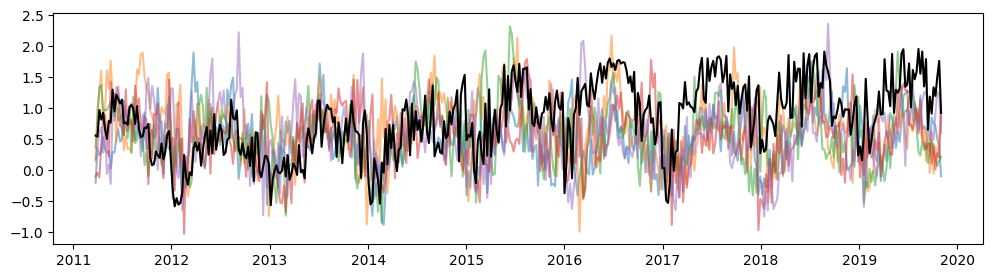

In [24]:
plt.figure(figsize=(12, 3))
fakes = gan.sample(test_data, n_samples=5)
for fake in fakes:
    plt.plot(fake.supply, alpha=0.5)
plt.plot(test_target, c='black')
plt.show()

In [25]:
fake_target = fakes[0][target.columns]
fake_cov = fakes[0][cov.columns]

In [26]:
ks_2samp(
    (fake_target - fake_target.shift(1)).supply, 
    (test_target - test_target.shift(1)).supply
).pvalue

0.20538699539865854

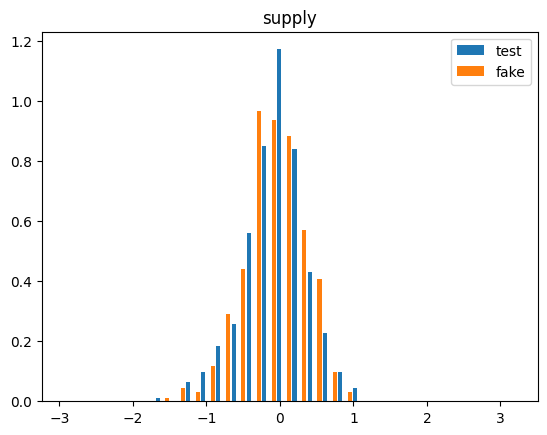

In [27]:
hist2samp(test_target, fake_target, 'test', 'fake', nbins=30)

/Users/vitalijpozdnakov/miniconda3/envs/genrisk/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


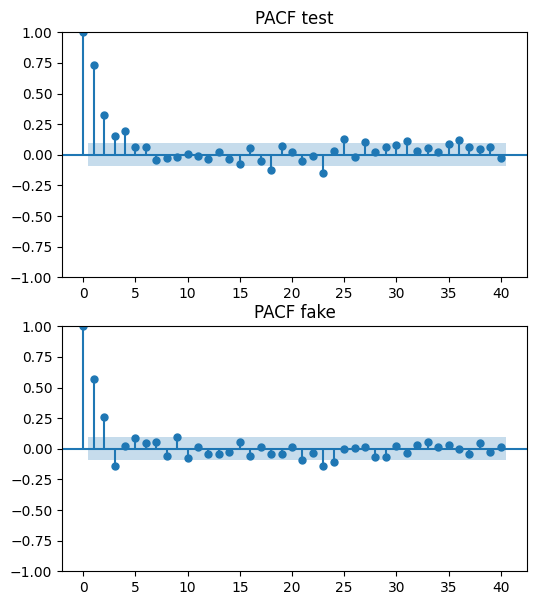

In [28]:
pacf2samp(test_target, fake_target, 'test', 'fake')

In [29]:
fake_index = pd.date_range(
    start=test_target.index[0],
    periods=len(test_target)*1,
    freq=test_target.index.freq
)
fake_cov = positional_encoding(fake_index, ['weekofyear'])
fake_target = gan.sample(fake_cov, n_samples=1)[0][target.columns]

/Users/vitalijpozdnakov/Yandex.Disk.localized/Data Science/dsc23-tutorial/dsctutorial/utils.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(index, freq)


In [30]:
fake_lstm_error = backtest(lstm_model, input_size=10, horizon=100, target=fake_target, cov=fake_cov)
fake_lstm_error.mean()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 341/341 [00:17<00:00, 19.74it/s]


0.2813642339575241

### Worst-case risk on fake data

In [31]:
fake_input_seq = input_seq_dataset(
    input_size=10, horizon=100,
    target=fake_target,
    cov=fake_cov,
    lags=5)
fake_input_seq

100%|██████████████████████████████████████████████████████████████████████████████████████████| 341/341 [00:00<00:00, 1091.55it/s]


,supply_diff1,supply_diff2,supply_diff3,supply_diff4,supply_diff5,weekofyear_cos,weekofyear_sin
2011-05-27,0.171776,0.154898,-0.071838,0.065479,0.509915,-0.766044,0.642788
2011-06-03,-0.224231,-0.052455,-0.069333,-0.296069,-0.158752,-0.835488,0.549509
2011-06-10,0.376299,0.152068,0.323845,0.306966,0.080230,-0.893633,0.448799
2011-06-17,0.181415,0.557714,0.333483,0.505260,0.488381,-0.939693,0.342020
2011-06-24,-0.174224,0.007191,0.383491,0.159259,0.331036,-0.973045,0.230616
...,...,...,...,...,...,...,...
2017-11-03,-0.328975,-0.262129,-0.989121,-1.010786,-1.185951,0.396080,-0.918216
2017-11-10,0.231902,-0.097073,-0.030226,-0.757219,-0.778884,0.500000,-0.866025
2017-11-17,0.189340,0.421243,0.092267,0.159114,-0.567878,0.597159,-0.802123
2017-11-24,0.632179,0.821519,1.053421,0.724446,0.791293,0.686242,-0.727374


In [32]:
alphaspace = np.linspace(0.1, 0.9, 9)
fake_lstm_risk = []
for alpha in tqdm(alphaspace):
    shift_model = ConditionalShift(mutable_columns, immutable_columns, alpha=alpha)
    shift_model.fit(fake_input_seq, fake_lstm_error)
    fake_lstm_risk.append((shift_model.risk, shift_model.lb_risk, shift_model.ub_risk))
fake_lstm_risk = np.array(fake_lstm_risk)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.71s/it]


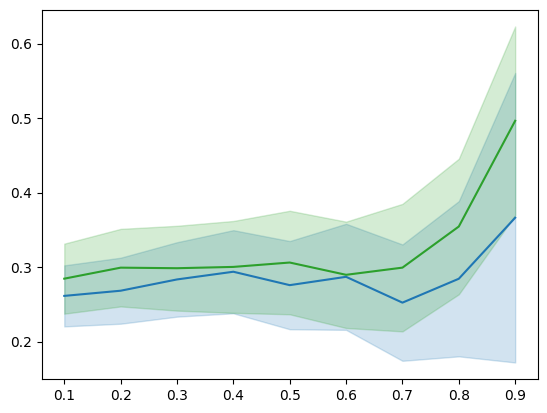

In [33]:
plt.plot(alphaspace, test_lstm_risk[:, 0], c='tab:blue')
plt.fill_between(alphaspace, test_lstm_risk[:, 1], test_lstm_risk[:, 2], alpha=0.2, color='tab:blue')

plt.plot(alphaspace, fake_lstm_risk[:, 0], c='tab:green')
plt.fill_between(alphaspace, fake_lstm_risk[:, 1], fake_lstm_risk[:, 2], alpha=0.2, color='tab:green')

plt.show()